In [4]:
import quandl
import yaml
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
# with open('keys.yaml', 'r') as fstream:
#     keys = yaml.load(fstream, yaml.SafeLoader)
# fstream.close()

# Steps


-  Introduction
-  Setup
    -  Import the datasets
    -  Visualize the Time Series
    -  Cleaning
-  Run
    -  Convert to return
    -  Calculate rolling beta

## Introduction

We will calculate rolling 36 monthe CAPM beta of IBM.

## Setup

Dataset used:

|#| ticker/Index   | Data Provider   | Ticker              | Frequency |
|-|----------------|-----------------|---------------------|-----------|
|1| IBM            | Yahoo Finance   | IBM                 | Daily     |
|2| S&P 500 TR     | Yahoo Finance   | SP500TR             | Daily     |
|3| Risk Free Rate | Fred            | TB3MS               | Monthly   |


## Run

Note:
We convert the annual yield to monthly value by dividing by 1200. 
This is not the risk free rate strictly speaking.
but it is close to Rf for all practical purposes.

We use the dividend adjusted and split prices to monthly returns

In [52]:
# !pip install yfinance
# !pip install quandl
# !pip install fredapi

In [59]:
from fredapi import Fred
fred = Fred(keys['fred'])
rfdf = fred.get_series('TB3MS')
rfdf = rfdf.to_frame('Rf')
rfdf.index += pd.offsets.MonthEnd()
#Monthly 3 month treasury bill (secondary market)

In [7]:
import yfinance as yf
import datetime as dt
import pandas as pd
stdt = "1998-01-03"
endt = dt.datetime.today().strftime('%Y-%m-%d')
sp500df = pd.read_csv('SPTR.csv')
ibmdf = pd.read_csv('IBM.csv')
file_end_date = pd.to_datetime(sp500df['Date'].iloc[-1])
day_old = (file_end_date - pd.to_datetime(endt)).days

if day_old > 30:
    stdt = (file_end_date + pd.offsets.BDay()).strftime('%Y-%m-%d')
    print('Re-downloading from {:s} and appending to existing file'.format(file_end_date.strftime))
    sp500df = pd.concat([sp500df, yf.download("^SP500TR", start=stdt, end=endt)], axis=1)
    ibmdf   = pd.concat([ibmdf, yf.download("IBM", start=stdt, end=endt)], axis=1)
    ibmdf.to_csv('IBM.csv')
    sp500df.to_csv('SPTR.csv')

    

In [11]:
ibmdf['Date'] = pd.to_datetime(ibmdf.Date)
ibmdf.set_index('Date', inplace=True)
sp500df['Date'] = pd.to_datetime(sp500df.Date)
sp500df.set_index('Date', inplace=True)

regdata = ibmdf.loc[:, 'Adj Close'].to_frame('IBM').join(sp500df.loc[:, 'Close'].to_frame('Rm'), how='left')

In [13]:
regdata.tail()

,IBM,Rm
Date,,
2020-05-18,121.559998,6037.899902
2020-05-19,120.290001,5975.149902
2020-05-20,121.379997,6075.759766
2020-05-21,119.120003,6028.930176
2020-05-22,118.389999,6044.160156


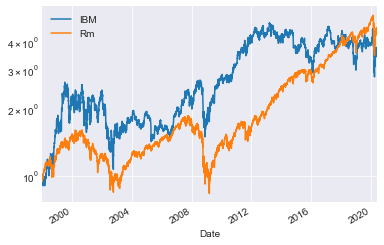

In [14]:
regdata.div(regdata.iloc[0,:]).plot(logy=True)

In [15]:
#fill down to end of month
#convert data to monthly
#price to return
data = regdata.ffill().\
       resample('M').last().\
       pct_change().\
       join(rfdf/1200, how='left')
# data['Rf'] = data['Rf'].ffill()
data = data.dropna()

NameError: name 'rfdf' is not defined

In [163]:
exdata = data.loc[:, data.columns[:2]].sub(data.loc[:, data.columns[2]], axis=0)

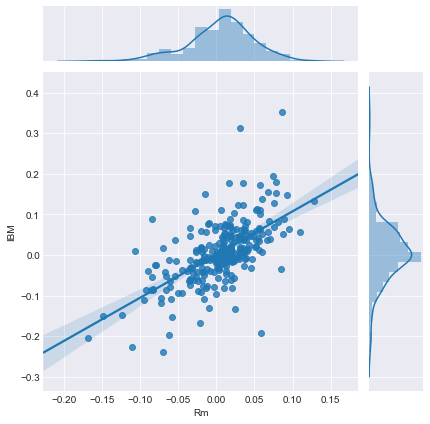

In [164]:
import seaborn as sns
sns.jointplot(x='Rm', y='IBM', data=exdata, kind="reg")

In [16]:
import statsmodels.api as sm
def calc_beta(s, df, col, mktcol, robust=False):    
    X = sm.add_constant(df.loc[s.index, mktcol])
    y = df.loc[s.index, col]
    if not robust:
        model = sm.OLS(y, X)
    else:
        model = sm.RLM(y, X)
    reg = model.fit()
    return reg.params[1]
print('Full sample Beta (non-Robust) {:3.2f}'.format(calc_beta(exdata, exdata, 'IBM', 'Rm')))
print('Full sample Beta (Robust)     {:3.2f}'.format(calc_beta(exdata, exdata, 'IBM', 'Rm', robust=True)))
beta = exdata.loc[:, ['IBM']].rolling(window=60).apply(calc_beta, raw=False, args=(exdata, 'IBM', 'Rm'))
fig, ax = plt.subplots(1,1)
ax.plot(beta.dropna())

NameError: name 'exdata' is not defined

In [169]:
beta.tail().round(2)

,IBM
Date,
2019-12-31,1.34
2020-01-31,1.33
2020-02-29,1.29
2020-03-31,1.27
2020-04-30,1.24


<img src='ibm_beta.png'>

In [154]:
# https://docs.quandl.com/docs/python-time-series
aapl = quandl.get('EOD/AAPL', api_key = keys['quandl'], start_date=stdt, end_date=endt, collapse="monthly")

In [155]:
aapl.head()

,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
Date,,,,,,,,,,,,
2013-09-30,477.25,481.66,474.411,476.750,9291300.0,0.0,1.0,60.686516,61.247287,60.325513,60.622937,65039100.0
2013-10-31,525.00,527.49,521.270,522.702,9846300.0,0.0,1.0,66.758347,67.074972,66.284045,66.466136,68924100.0
2013-11-30,549.48,558.33,547.810,556.070,11361700.0,0.0,1.0,70.280291,71.412235,70.066693,71.123174,79531900.0
2013-12-31,554.17,561.28,554.000,561.020,7967300.0,0.0,1.0,70.880157,71.789550,70.858414,71.756295,55771100.0
2014-01-31,495.18,501.53,493.550,500.600,16599900.0,0.0,1.0,63.335143,64.147329,63.126661,64.028379,116199300.0


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [ ]:
https://www.statsmodels.org/stable/examples/index.html
    